# Inviscid Solver (Panel Method)

In [36]:
import numpy as np
import matplotlib.pyplot as plt

from src.fields import Body, Freestream, BoundaryLayer
from src.utils.naca_generator import generate_naca4
from src.solver import VortexPanelMethod, BoundaryLayerSolver, vortex_panel_method
from src.utils.coefficient import compute_cl_from_cp

# # Inputs
# naca_series = "2412"
naca_series = "4412"
N = 100

# freestream properties
density = 1.225
viscosity = 1.837e-5
nu = viscosity / density
U_inf = 1.4996e+0
AoA_deg = 0
AoA_rad = np.deg2rad(AoA_deg)

airfoil = Body(*generate_naca4(series=naca_series, N=N, cosine_spacing=True, closed_te=True))
freestream = Freestream(U_inf=U_inf, AoA_rad=AoA_rad, density=density, viscosity=viscosity, nu=nu)
boundary_layer = BoundaryLayer(U_e=freestream.U_inf, AoA_rad=AoA_rad, N=airfoil.N, methods="thwaites")

airfoil.add_boundary_layer(boundary_layer)
X, VpVinf, Cp = VortexPanelMethod.solve(body=airfoil, freestream=freestream)
airfoil.update_edge_velocity(U_e=VpVinf * freestream.U_inf)
airfoil.get_stagnation_points()

# Solve vortex panel
Cl = compute_cl_from_cp(X, Cp)

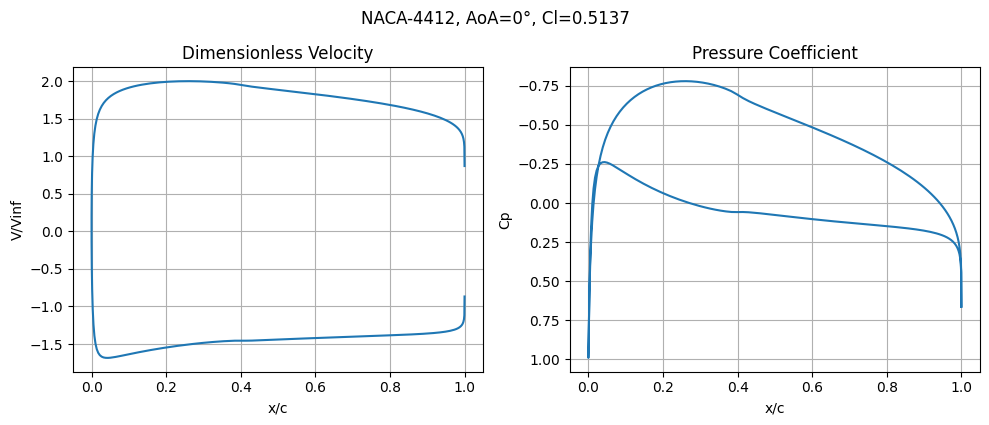

In [37]:
# Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(X, airfoil.U_e)
plt.title("Dimensionless Velocity")
plt.xlabel("x/c"); plt.ylabel("V/Vinf")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(X, Cp)
plt.gca().invert_yaxis()
plt.title("Pressure Coefficient")
plt.xlabel("x/c"); plt.ylabel("Cp")
plt.tight_layout()
plt.suptitle(f"NACA-{naca_series}, AoA={AoA_deg}°, Cl={Cl:.4f}", y=1.05)
plt.grid(True)
plt.show()

0.49882558989755515 -0.013959565721134534


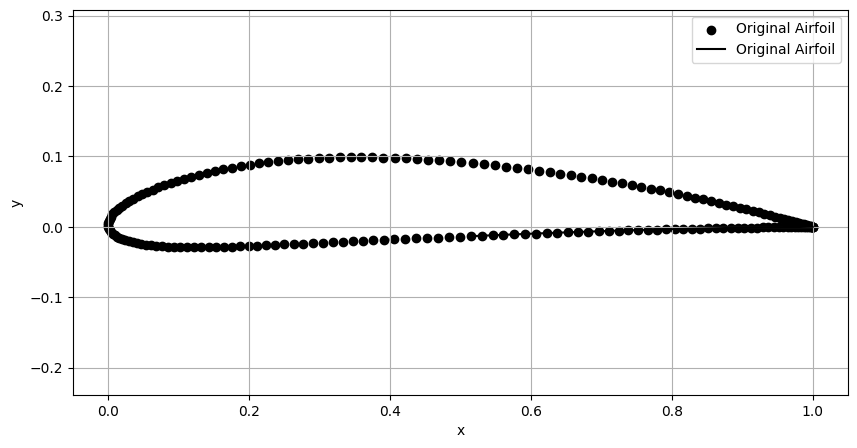

In [38]:
print(airfoil.XB[50], airfoil.YB[50])

plt.figure(figsize=(10, 5))
plt.scatter(airfoil.XB, airfoil.YB, label='Original Airfoil', color='black')
plt.plot(airfoil.XB[:50], airfoil.YB[:50], label='Original Airfoil', color='black')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Viscous Solver (Thwaites Method)

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_displaced_geometry(old_XB, old_YB, new_XB, new_YB, Xc=None, Yc=None, delta_star=None):
    XB, YB = old_XB, old_YB
    XB_new, YB_new = new_XB, new_YB
    plt.figure(figsize=(10, 5))

    # Original airfoil
    plt.plot(XB, YB, label='Original Airfoil', color='black')

    # Displaced airfoil
    plt.plot(XB_new, YB_new, label='Displaced by δ*', color='red')

    # Optional: plot normal vectors at control points
    if Xc is not None and Yc is not None and delta_star is not None:
        # Recompute normals
        dX = XB[1:] - XB[:-1]
        dY = YB[1:] - YB[:-1]
        lengths = np.sqrt(dX**2 + dY**2)
        tx = dX / lengths
        ty = dY / lengths
        nx = -ty
        ny = tx

        # Normalize and scale normal vectors for display
        scale = 1.0  # display scale for visibility
        for i in range(len(Xc)):
            plt.arrow(Xc[i], Yc[i], delta_star[i]*nx[i]*scale, delta_star[i]*ny[i]*scale,
                      head_width=0.001, head_length=0.002, fc='blue', ec='blue')

    plt.axis('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.legend()
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.2, 0.2)
    plt.title('Airfoil Geometry Displaced by Boundary Layer Thickness δ*')
    plt.show()


In [40]:
airfoil.stagnation_index

100

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


transition_upper_index: 199, transition_lower_index: 0


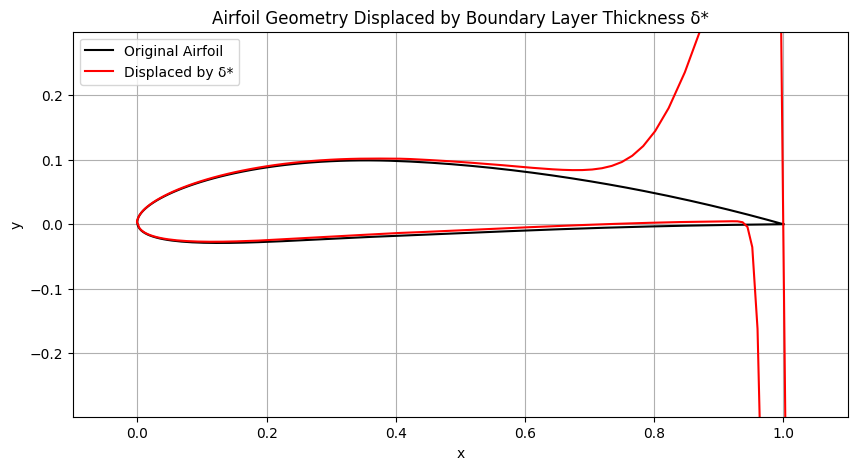

In [41]:
from src.solver import BoundaryLayerSolver

VpVinf[airfoil.stagnation_index] = 0
airfoil.update_edge_velocity(U_e=VpVinf * freestream.U_inf)

# one pass of laminar boundary layer
bl_solver = BoundaryLayerSolver(laminar_methods="thwaites", transition_method="michel", turbulent_methods="drela")
theta, delta_star, H, transition_upper_index, transition_lower_index, dudx_log = bl_solver.solve_laminar_boundary_layer(body=airfoil, freestream=freestream)

airfoil.update_boundary_layer(theta=theta, delta_star=delta_star, H=H, transition_index_upper=transition_upper_index, transition_index_lower=transition_lower_index)
XB_new, YB_new = airfoil.displace_geometry_by_dstar()
print(f"transition_upper_index: {transition_upper_index}, transition_lower_index: {transition_lower_index}")

plot_displaced_geometry(airfoil.XB, airfoil.YB, XB_new, YB_new)

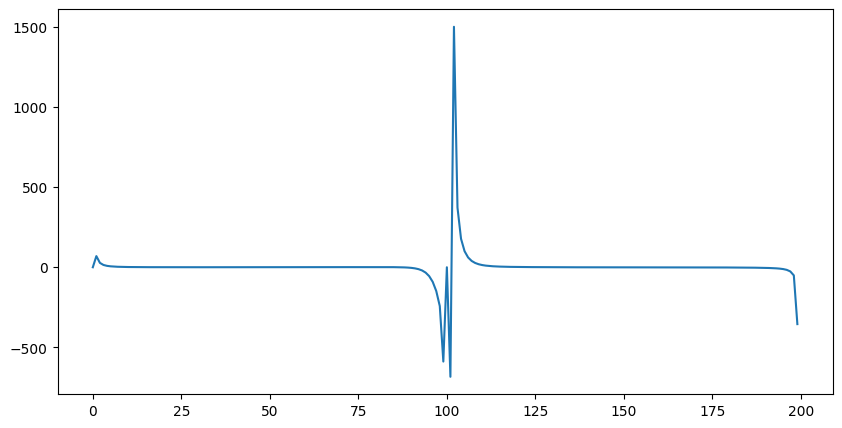

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(dudx_log)
plt.show()

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


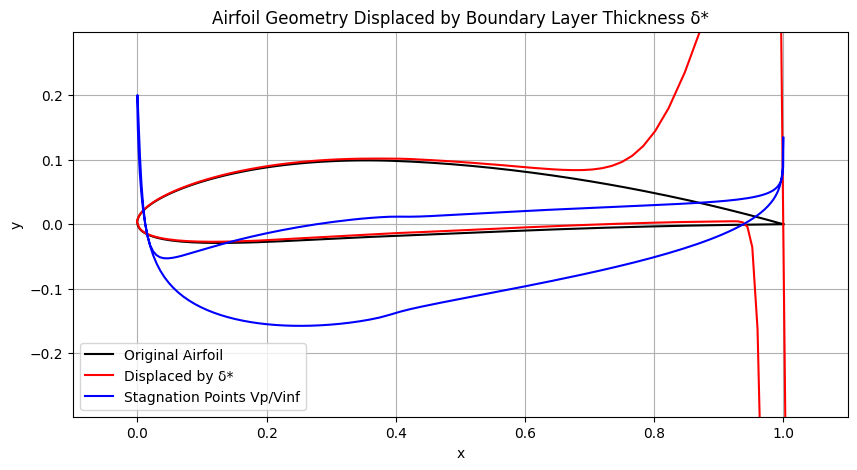

In [43]:
XB, YB = airfoil.XB, airfoil.YB
plt.figure(figsize=(10, 5))
Xc, Yc = None, None
# Original airfoil
plt.plot(XB, YB, label='Original Airfoil', color='black')
# Displaced airfoil
plt.plot(XB_new, YB_new, label='Displaced by δ*', color='red')
# VpVinf
# plt.plot(XB[:-1], VpVinf/(VpVinf.max()*5), label='Stagnation Points Vp/Vinf', color='blue')
plt.plot(XB[:-1], Cp/(Cp.max()*5), label='Stagnation Points Vp/Vinf', color='blue')
# plt.plot(XB[:-1], dudx_log/ (dudx_log.max()*5), label='dUedx', color='blue')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.2, 0.2)
plt.title('Airfoil Geometry Displaced by Boundary Layer Thickness δ*')
plt.show()

In [44]:
N, theta.shape, delta_star.shape, H.shape, transition_upper_index, transition_lower_index

(100, (200,), (200,), (200,), 199, 0)

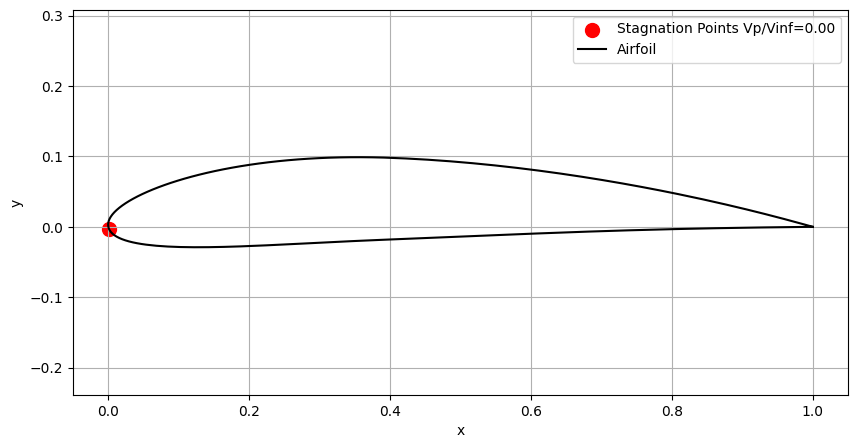

In [45]:
min_index = int(np.argmin(np.abs(VpVinf))) 

plt.figure(figsize=(10, 5))
plt.scatter(airfoil.XB[99], airfoil.YB[99], label=f'Stagnation Points Vp/Vinf={VpVinf[min_index]:.2f}', color='red', s = 100, marker='o')
plt.plot(airfoil.XB, airfoil.YB, label='Airfoil', color='black')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.5, 0.5)
plt.legend()
plt.show()

In [46]:
theta.shape, delta_star.shape, H.shape, transition_index

NameError: name 'transition_index' is not defined

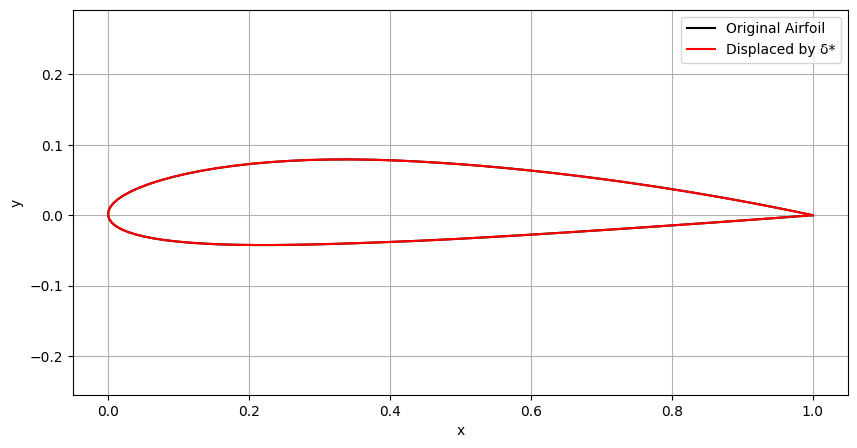

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(airfoil.XB, airfoil.YB, label='Original Airfoil', color='black')
plt.plot(airfoil.XB, airfoil.YB, label='Displaced by δ*', color='red')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()

# Turbulent Boundary Layer Solver (Drela Method)